In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import itertools
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.stattools import grangercausalitytests
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
DISPOSAL_FILEPATH = "../../data/raw/council_disposal_receipts.xlsx"

YEAR_SKIP_MAPPING = {
    "2014": 0,
    "2015": 0,
    "2016": 2,
    "2017": 3,
    "2018": 3,
    "2019": 4,
    "2020": 4,
    "2021": 4,
    "2022": 4,
    "2023": 4,
}

dfs = []
for year, skip_row in YEAR_SKIP_MAPPING.items():
    df = pd.read_excel(DISPOSAL_FILEPATH, skiprows=skip_row, sheet_name=year)
    dfs.append(df)

dataset = pd.read_csv(r'../../data/processed/charity_main_cleaned.csv')

In [3]:
def clean_sheet(df, rename_from_col=3, header_row=1):
    """
    Cleans a DataFrame read from Excel:
    - Replaces values in `header_row` with column names starting from `rename_from_col`
    - Keeps all columns up to `rename_from_col`
    - Keeps only renamed columns after `rename_from_col`
    - Sets row `header_row` as the header and drops all rows above it
    """
    # Step 1: Identify renamed columns
    renamed_mask = [not str(col).startswith("Unnamed:") for col in df.columns]

    # Step 2: Determine which columns to keep
    cols_to_keep = list(range(rename_from_col + 1))  # Always keep up to and including `rename_from_col`
    for i in range(rename_from_col + 1, len(df.columns)):
        if renamed_mask[i]:
            cols_to_keep.append(i)

    # Step 3: Overwrite header_row with column names for renamed columns
    for i in range(rename_from_col, len(df.columns)):
        if renamed_mask[i]:
            df.iloc[header_row, i] = df.columns[i]

    # Step 4: Set row `header_row` as header and drop rows above
    df.columns = df.iloc[header_row]
    df = df.drop(index=list(range(header_row + 1))).reset_index(drop=True)

    # Step 5: Keep only selected columns
    df = df.iloc[:, cols_to_keep]

    return df

def rename_and_filter_disposal(df, start_col=5, keyword=": Disposal of tangible fixed assets"):
    """
    Keeps:
    - All columns before `start_col`
    - Columns from `start_col` onward that contain `keyword`
    
    Renames matching columns by removing the keyword from their name.
    """
    cols_to_keep = list(range(start_col))  # Keep early columns as-is

    new_columns = df.columns.tolist()  # Copy of column names

    for i in range(start_col, len(df.columns)):
        col = str(df.columns[i])
        if keyword in col:
            # Rename column by removing the keyword
            new_columns[i] = col.replace(keyword, "")
            cols_to_keep.append(i)

    # Apply renaming
    df.columns = new_columns

    # Keep only selected columns
    return df.iloc[:, cols_to_keep]

dfs[0] = clean_sheet(dfs[0], rename_from_col=3, header_row=1)
dfs[1] = clean_sheet(dfs[1], rename_from_col=4, header_row=1)
dfs[2] = clean_sheet(dfs[2], rename_from_col=4, header_row=2)
dfs[3] = clean_sheet(dfs[3], rename_from_col=5, header_row=0)
dfs[4] = clean_sheet(dfs[4], rename_from_col=5, header_row=0)

dfs[5] = rename_and_filter_disposal(dfs[5], start_col=5)
dfs[6] = rename_and_filter_disposal(dfs[6], start_col=5)
dfs[7] = rename_and_filter_disposal(dfs[7], start_col=5)
dfs[8] = rename_and_filter_disposal(dfs[8], start_col=5)
dfs[9] = rename_and_filter_disposal(dfs[9], start_col=6)

In [4]:
for i in range(10):
    df = dfs[i]

    # Step 1: Standardise column names first
    df.columns = df.columns.str.strip().str.lower()
    if 'la name' in df.columns:
        df = df.rename(columns={'la name': 'local_authority'})
    
    if 'local_authority' in df.columns:
        df['local_authority'] = df['local_authority'].str.replace(r'(?i)\(ua\)|\bua\b', '', regex=True).str.strip()

    # Step 2: Drop bad values in first column
    first_col = df.columns[0]
    df = df[~df[first_col].isin([pd.NA, None, '[z]', 'la_lgf_code'])]
    df = df.dropna(subset=[first_col])

    # Step 3: Drop missing ONS codes
    if i == 0 and 'ecode' in df.columns:
        df = df.dropna(subset=['ecode'])
    elif i != 0 and 'ons code' in df.columns:
        df = df.dropna(subset=['ons code'])

    # Step 4: Drop unwanted council classes
    if 'class' in df.columns:
        df = df[~df['class'].isin(['O','SC'])]

    # Save cleaned frame back
    dfs[i] = df

In [23]:
dfs[0]

,ecode,local_authority,class,non-school funding,airports,recreation & sport,open spaces,tourism,library services,total culture & related services,...,total public health,"roads, street lighting & road safety",total fire & rescue services,total central services,street cleaning (not chargeable to highways),total planning & development,total trading services,total education,total highways & transport,financial_year
0,E3831,adur,SD,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2014
1,E0931,cumberland,SD,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2014
2,E1031,amber valley,SD,0,0,36,0,0,0,0,...,0,0,0,0,0,0,15,0,0,2014
3,E3832,arun,SD,0,0,0,0,0,0,0,...,0,0,0,418,0,0,0,0,0,2014
4,E3031,ashfield,SD,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438,E1838,wychavon,SD,0,0,24,0,0,0,14,...,0,0,0,0,0,0,121,0,0,2014
439,E0435,buckinghamshire,SD,0,0,0,0,0,0,0,...,0,0,0,0,0,4752,0,0,0,2014
440,E2344,wyre,SD,0,0,0,0,0,0,0,...,0,0,0,2003,0,0,0,0,0,2014
441,E1839,wyre forest,SD,0,0,0,10,0,0,0,...,0,0,0,0,0,0,717,0,0,2014


In [6]:
merge_columns = {
    "community safety": ["community safety", "community safety (cctv)"],
    'agricultural & fisheries services':['agriculture & fisheries'],
    'all services total':['total all services','all services'],
    'early years & primary schools':['pre-primary & primary education'],
    'parking':['parking of vehicles'],
    'ports & piers':['local authority ports & piers'],
    'special schools & alternative provision':['special education'],
    'secondary schools':['secondary education'],
    'total industrial & commercial trading':['industrial & commercial trading'],
    'total environmental & regulatory services':['total environmental services','regulatory services (environmental health)'],
    'tolled roads, bridges, tunnels,ferries & public transport companies':['tolled road bridges, tunnels, ferries, public transport companies','tolled road bridges, tunnels, ferries & public transport companies'],
    'public transport (bus)':['public passenger transport - bus'],
    'public transport (rail & other)':['public passenger transport - rail & other'],
    'total housing':['housing'],
    'total police':['police'],
    'total social care':['social services','social care'],
    'total public health':['public health'],
    'roads, street lighting & road safety':['roads, street lights & safety'],
    'total fire & rescue services':['fire & rescue services'],
    'total central services':['central services (including court services)'],
    'street cleaning (not chargeable to highways)':['street cleaning not chargeable to highways'],
    'total planning & development':['total planning & development services','planning & development services'],
    'total trading services':['total trading','trading'],
    'total education':['education'],
    'total highways & transport':['total transport','highways & transport'],
    'total culture & related services':['culture & heritage']

    #'commercial housing',
    #'energy generation & supply',
    #'finance & insurance activity',
    #'hospitality & catering',
    #'lgf code',
    #'ons code',
    #'other commercial activity',
    #'other real estate activities',
    #'post-16 provision & other education',
    #'subclass',
    #'total digital infrastructure',
    #'water supply, sewerage & remediation'
}

# Standardise and merge alias columns across all dfs
for idx in range(len(dfs)):
    df = dfs[idx].copy()
    df.columns = [
        str(col).strip().lower()
        .replace(" and ", " & ")
        for col in df.columns
    ]

    dfs[idx] = df  # Save the cleaned version

    for standard_col, aliases in merge_columns.items():
        # Find which alias columns are present
        present_cols = [col for col in aliases if col in df.columns]
        if not present_cols:
            continue  # Nothing to merge for this category

        # Sum across all present columns
        df[standard_col] = df[present_cols].sum(axis=1, skipna=True)

        # Drop duplicates, except the one we’re keeping
        cols_to_drop = [col for col in present_cols if col != standard_col]
        df.drop(columns=cols_to_drop, inplace=True)

    dfs[idx] = df  # Save the cleaned DataFrame back

In [7]:
# Combined mapping: new_name → list of old names
unified_map = {
    'buckinghamshire': ['aylesbury vale', 'chiltern', 'south bucks', 'wycombe','south buckinghamshire'],
    'dorset': ['weymouth and portland', 'west dorset', 'north dorset', 'east dorset', 'purbeck', 'christchurch'],
    'somerset': ['taunton deane', 'west somerset', 'mendip', 'sedgemoor', 'south somerset', 'somerset council','somerset west and taunton'],
    'cumberland': ['allerdale', 'carlisle', 'copeland', 'cumberland council'],
    'westmorland and furness': ['barrow in furness', 'barrow-in-furness', 'eden', 'south lakeland'],
    'north yorkshire': ['craven', 'hambleton', 'harrogate', 'richmondshire', 'ryedale', 'scarborough', 'selby', 'north yorkshire council'],
    'bournemouth christchurch and poole': ['bournemouth', 'christchurch', 'poole'],
    'west suffolk': ['forest heath', 'st edmundsbury'],
    'east suffolk': ['suffolk coastal', 'waveney'],
    'bath and north east somerset': ['bath and ne somerset'],
    'southend-on-sea': ['southend on sea'],
    'leicester': ['leicester city'],
    'medway': ['medway towns'],
    'derby': ['derby city'],
    'folkestone and hythe': ['shepway'],
    'county durham': ['durham'],
    "king's lynn and west norfolk": ['kings lynn and west norfolk'],
    'north northamptonshire': ['wellingborough', 'east northamptonshire', 'kettering', 'corby'],
    'west northamptonshire': ['northampton', 'south northamptonshire', 'daventry'],
}
# old_name → new_name (lowercase)
flat_lookup = {
    old.lower(): new.lower()
    for new, olds in unified_map.items()
    for old in olds
}
def clean_local_authority(name):
    if pd.isna(name):
        return name
    name = str(name).lower()
    name = (
        name.replace('&', 'and')
        .replace('-', ' ')
        .replace(',', '')
        .replace('.', '')
        .replace(' city of', '')
        .replace(' county of', '')
        .strip()
    )
    return flat_lookup.get(name, name)
# Apply to disposal files
for i in range(len(dfs)):
    if 'local_authority' in dfs[i].columns:
        dfs[i]['local_authority'] = dfs[i]['local_authority'].apply(clean_local_authority)

# Apply to charity dataset
if 'local_authority' in dataset.columns:
    dataset['local_authority'] = dataset['local_authority'].apply(clean_local_authority)

# List of known devolved nation council names to exclude
non_england_keywords = [
    'aberdeen', 'aberdeenshire', 'angus', 'antrim', 'ards', 'argyll', 'armagh', 'belfast', 'blaenau', 'bridgend',
    'caerphilly', 'cardiff', 'carmarthenshire', 'causeway', 'ceredigion', 'conwy', 'denbighshire', 'derry',
    'dumfries', 'dundee', 'east ayrshire', 'east dunbartonshire', 'east lothian', 'east renfrewshire', 'falkirk',
    'fermanagh', 'fife', 'flintshire', 'glasgow', 'gwynedd', 'highland', 'inverclyde', 'isle of man',
    'isle of anglesey', 'lisburn', 'merthyr', 'mid and east antrim', 'mid ulster', 'midlothian', 'monmouthshire',
    'moray', 'na h eileanan siar', 'neath', 'newport', 'newry', 'north ayrshire', 'north lanarkshire', 'orkney',
    'pembrokeshire', 'perth and kinross', 'powys', 'renfrewshire', 'rhondda', 'scottish borders', 'shetland',
    'south ayrshire', 'south lanarkshire', 'stirling', 'swansea', 'torfaen', 'vale of glamorgan', 'west dunbartonshire',
    'west lothian', 'wrexham','city of edinburgh','channel islands'
]

# Convert to lowercase and filter out rows containing these names
dataset['local_authority_lower'] = dataset['local_authority'].str.lower()
dataset = dataset[~dataset['local_authority_lower'].str.contains('|'.join(non_england_keywords), na=False)]

# Drop the helper column
dataset = dataset.drop(columns=['local_authority_lower'])


In [8]:
# Step 1: Get unique local_authority names from dfs[0–9]
all_disposal_names = set()
for i in range(10):
    if 'local_authority' in dfs[i].columns:
        all_disposal_names.update(dfs[i]['local_authority'].dropna().unique())

# Step 2: Get unique local_authority names from dataset
if 'local_authority' in dataset.columns:
    charity_names = set(dataset['local_authority'].dropna().unique())
else:
    raise KeyError("'local_authority' column not found in dataset")

# Step 3: Find mismatches
in_disposal_not_in_charity = all_disposal_names - charity_names
in_charity_not_in_disposal = charity_names - all_disposal_names

# Step 4: Print results
print("In disposal (dfs[0–9]) but NOT in charity dataset:")
print(sorted(in_disposal_not_in_charity))

print("\n In charity dataset but NOT in disposal (dfs[0–9]):")
print(sorted(in_charity_not_in_disposal))


In disposal (dfs[0–9]) but NOT in charity dataset:
[]

 In charity dataset but NOT in disposal (dfs[0–9]):
[]


In [9]:
# Step 1: Assign financial year to each DataFrame in dfs
years = list(range(2014, 2024))
for i, year in enumerate(years):
    if not dfs[i].empty:
        dfs[i]['financial_year'] = year

# Step 2: Melt each DataFrame into long format
long_frames = []
for i, df in enumerate(dfs):
    if df.empty:
        continue
    long_df = df.melt(
        id_vars=["local_authority", "financial_year"],
        value_vars=[
            col for col in df.columns 
            if col not in ["ecode", 'lgf code', 'ons code', "class", "subclass", 
                           "local_authority", "financial_year", 'certification complete']
        ],
        var_name="category",
        value_name="value"
    )
    long_frames.append(long_df)

# Step 3: Combine all disposal long-format DataFrames
disposal_long_df = pd.concat(long_frames, ignore_index=True)

# Step 4: Filter for 'all services total' category only
disposal_long_df = disposal_long_df[disposal_long_df['category'] == 'all services total']

# Step 5: Aggregate any duplicate disposal entries
disposal_long_df = disposal_long_df.groupby(['local_authority', 'financial_year', 'category']).agg({
    'value': 'sum'
}).reset_index()

# Step 6: Count removals from charity dataset and aggregate duplicates
removals = (
    dataset
    .groupby(['local_authority', 'removal_fy', 'size_category'])
    .size()
    .reset_index(name='removals')
    .rename(columns={'removal_fy': 'financial_year'})
)

# Step 7: Merge disposal data with charity removals
panel = pd.merge(
    disposal_long_df,
    removals,
    on=["financial_year", "local_authority"],
    how="outer"
)

# Step 8: Replace NaNs in 'removals' with 0 and filter years
panel['removals'] = panel['removals'].fillna(0).astype(int)
panel = panel[(panel['financial_year'] >= 2015) & (panel['financial_year'] <= 2023)]
panel['value'] = pd.to_numeric(panel['value'], errors='coerce')/1000 # original unit - thousand - to million

In [10]:
# Get all unique values for each dimension (excluding NaN values)
unique_years = panel['financial_year'].unique()
unique_authorities = panel['local_authority'].unique()
unique_size_categories = panel['size_category'].dropna().unique()

# Create all possible combinations
all_combinations = list(itertools.product(unique_years, unique_authorities, unique_size_categories))

# Convert to DataFrame
complete_index = pd.DataFrame(all_combinations, 
                             columns=['financial_year', 'local_authority', 'size_category'])

# Merge with original panel data
complete_panel = pd.merge(
    complete_index,
    panel,
    on=['financial_year', 'local_authority', 'size_category'],
    how='left'
)

# Fill missing values appropriately
# For 'removals' column, fill with 0 (no removals)
complete_panel['removals'] = complete_panel['removals'].fillna(0).astype(int)
# Fill missing 'value' and 'category' by forward filling within each local_authority-financial_year group
complete_panel['value'] = complete_panel.groupby(['local_authority', 'financial_year'])['value'].transform('first')


In [11]:
# Ensure proper sorting
filtered_panel = complete_panel.sort_values(by=['local_authority', 'size_category', 'financial_year'])
filtered_panel = filtered_panel.drop('category', axis=1)
filtered_panel = filtered_panel.dropna(subset=['value'])

# Create lagged value columns
filtered_panel['value_lag1'] = (
    filtered_panel
    .groupby(['local_authority', 'size_category'])['value']
    .shift(1)
)

filtered_panel['value_lag2'] = (
    filtered_panel
    .groupby(['local_authority', 'size_category'])['value']
    .shift(2)
)

filtered_panel['value_lag3'] = (
    filtered_panel
    .groupby(['local_authority', 'size_category'])['value']
    .shift(3)
)


In [12]:
# ADF test on 'removals'
result_removals = adfuller(filtered_panel['removals'].dropna())
print("ADF Test for 'removals':")
print(f"ADF Statistic: {result_removals[0]}")
print(f"p-value: {result_removals[1]}")
print(f"Critical Values: {result_removals[4]}\n")

# ADF test on 'value'
result_value = adfuller(filtered_panel['value'].dropna())
print("ADF Test for 'value':")
print(f"ADF Statistic: {result_value[0]}")
print(f"p-value: {result_value[1]}")
print(f"Critical Values: {result_value[4]}")

ADF Test for 'removals':
ADF Statistic: -15.1516923142051
p-value: 6.783011156724133e-28
Critical Values: {'1%': np.float64(-3.431176354444547), '5%': np.float64(-2.8619051889218126), '10%': np.float64(-2.5669643854030992)}

ADF Test for 'value':
ADF Statistic: -9.231390121949659
p-value: 1.6746605679910621e-15
Critical Values: {'1%': np.float64(-3.4311766678362097), '5%': np.float64(-2.861905327399006), '10%': np.float64(-2.5669644591160705)}


In [13]:
# Run Engle-Granger cointegration test
coint_stat, p_value, crit_values = coint(filtered_panel['removals'], filtered_panel['value'])

print(f"Engle-Granger Cointegration Test")
print(f"Test Statistic: {coint_stat}")
print(f"p-value: {p_value}")
print(f"Critical Values: {crit_values}")

Engle-Granger Cointegration Test
Test Statistic: -15.02520792986576
p-value: 8.567686059211492e-27
Critical Values: [-3.8978183  -3.33689877 -3.04498359]


In [14]:
# Format data as a two-column array: [removals, value]
data = filtered_panel[['removals', 'value']].dropna()

# Run Granger causality test with up to 3 lags
grangercausalitytests(data, maxlag=3)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=58.8703 , p=0.0000  , df_denom=7946, df_num=1
ssr based chi2 test:   chi2=58.8925 , p=0.0000  , df=1
likelihood ratio test: chi2=58.6754 , p=0.0000  , df=1
parameter F test:         F=58.8703 , p=0.0000  , df_denom=7946, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=29.9708 , p=0.0000  , df_denom=7943, df_num=2
ssr based chi2 test:   chi2=59.9794 , p=0.0000  , df=2
likelihood ratio test: chi2=59.7542 , p=0.0000  , df=2
parameter F test:         F=29.9708 , p=0.0000  , df_denom=7943, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=21.3276 , p=0.0000  , df_denom=7940, df_num=3
ssr based chi2 test:   chi2=64.0393 , p=0.0000  , df=3
likelihood ratio test: chi2=63.7826 , p=0.0000  , df=3
parameter F test:         F=21.3276 , p=0.0000  , df_denom=7940, df_num=3


{np.int64(1): ({'ssr_ftest': (np.float64(58.87029143624064),
    np.float64(1.884068775397185e-14),
    np.float64(7946.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(58.892517823644205),
    np.float64(1.6652424337455314e-14),
    np.int64(1)),
   'lrtest': (np.float64(58.67542809385486),
    np.float64(1.8594932958851527e-14),
    np.int64(1)),
   'params_ftest': (np.float64(58.87029143625731),
    np.float64(1.8840687753811002e-14),
    np.float64(7946.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(29.97083684483573),
    np.float64(1.0781975952007094e-13),
    np.float64(7943.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(59.979406079001485),
    np.float64(9.454475832218251e-14),
    np.int64(2)),
   'lrtest': (np.float64(59.75422163881012),
    np.float64(1.0581217363372647e-13),
    np.int64(2)),
   'params_ftest': (np.float64(29.9708368448358),
    np.float64(1.0781975952002612e-13),
    np.float64(7943.0),
    2.0)},
   array([[

In [15]:
# Prepare data: ensure it's sorted and aligned
df = filtered_panel[['removals', 'value']].dropna().copy()
df = df.astype(float)

# Run Granger causality test: does 'removals' Granger-cause 'value'?
# maxlag = 3 for testing 1, 2, 3 lags
reverse_granger_results = grangercausalitytests(df[['value', 'removals']], maxlag=3, verbose=True)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=60.3524 , p=0.0000  , df_denom=7946, df_num=1
ssr based chi2 test:   chi2=60.3752 , p=0.0000  , df=1
likelihood ratio test: chi2=60.1471 , p=0.0000  , df=1
parameter F test:         F=60.3524 , p=0.0000  , df_denom=7946, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=10.0316 , p=0.0000  , df_denom=7943, df_num=2
ssr based chi2 test:   chi2=20.0759 , p=0.0000  , df=2
likelihood ratio test: chi2=20.0506 , p=0.0000  , df=2
parameter F test:         F=10.0316 , p=0.0000  , df_denom=7943, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.4949  , p=0.0037  , df_denom=7940, df_num=3
ssr based chi2 test:   chi2=13.4965 , p=0.0037  , df=3
likelihood ratio test: chi2=13.4850 , p=0.0037  , df=3
parameter F test:         F=4.4949  , p=0.0037  , df_denom=7940, df_num=3


c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


In [16]:
# Run OLS regression with fixed effects for LA and year
model = smf.ols(
    formula='removals ~ value + C(local_authority) + C(financial_year) + C(size_category)+value:C(size_category)',
    data=filtered_panel
).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               removals   R-squared:                       0.679
Model:                            OLS   Adj. R-squared:                  0.666
Method:                 Least Squares   F-statistic:                     52.46
Date:                Sat, 19 Jul 2025   Prob (F-statistic):               0.00
Time:                        21:36:23   Log-Likelihood:                -21855.
No. Observations:                7950   AIC:                         4.433e+04
Df Residuals:                    7641   BIC:                         4.649e+04
Df Model:                         308                                         
Covariance Type:            nonrobust                                         
                                                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------

In [17]:
model = smf.ols(
    formula=(
        'removals ~ '
        'value + value_lag1 + value_lag2 + value_lag3 + '
        'C(local_authority) + C(financial_year) + C(size_category) + '
        'value:C(size_category) + '
        'value_lag1:C(size_category) + '
        'value_lag2:C(size_category) + '
        'value_lag3:C(size_category)'
    ),
    data=filtered_panel
).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               removals   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.679
Method:                 Least Squares   F-statistic:                     36.66
Date:                Sat, 19 Jul 2025   Prob (F-statistic):               0.00
Time:                        21:36:23   Log-Likelihood:                -14541.
No. Observations:                5286   AIC:                         2.971e+04
Df Residuals:                    4972   BIC:                         3.177e+04
Df Model:                         313                                         
Covariance Type:            nonrobust                                         
                                                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------

In [18]:
filtered_panel[filtered_panel['local_authority']=='north yorkshire']

,financial_year,local_authority,size_category,value,removals,value_lag1,value_lag2,value_lag3
527,2015.0,north yorkshire,Large,12.347,1,NaN,NaN,NaN
1415,2016.0,north yorkshire,Large,8.831,0,12.347,NaN,NaN
2303,2017.0,north yorkshire,Large,8.675,0,8.831,12.347,NaN
3191,2018.0,north yorkshire,Large,7.503,2,8.675,8.831,12.347
4079,2019.0,north yorkshire,Large,9.843,2,7.503,8.675,8.831
4967,2020.0,north yorkshire,Large,6.915,0,9.843,7.503,8.675
5855,2021.0,north yorkshire,Large,6.349,0,6.915,9.843,7.503
6743,2022.0,north yorkshire,Large,8.708,0,6.349,6.915,9.843
7631,2023.0,north yorkshire,Large,8.157,0,8.708,6.349,6.915
526,2015.0,north yorkshire,Medium,12.347,17,NaN,NaN,NaN


In [19]:
top10_removals = filtered_panel.sort_values('removals', ascending=False).head(30)
print(top10_removals[['local_authority', 'financial_year', 'removals', 'value', 'size_category']])

      local_authority  financial_year  removals    value size_category
4392      westminster          2019.0        71   23.431         Small
3189  north yorkshire          2018.0        70    7.503         Small
5853  north yorkshire          2021.0        69    6.349         Small
1413  north yorkshire          2016.0        66    8.831         Small
4077  north yorkshire          2019.0        64    9.843         Small
6741  north yorkshire          2022.0        62    8.708         Small
3573           barnet          2019.0        60   11.125         Small
3597       birmingham          2019.0        58   70.092         Small
639          somerset          2015.0        55    7.729         Small
5967         somerset          2021.0        54    9.027         Small
3675           camden          2019.0        52   65.115         Small
4401        wiltshire          2019.0        52   15.853         Small
5373       birmingham          2021.0        51  122.030         Small
5499  

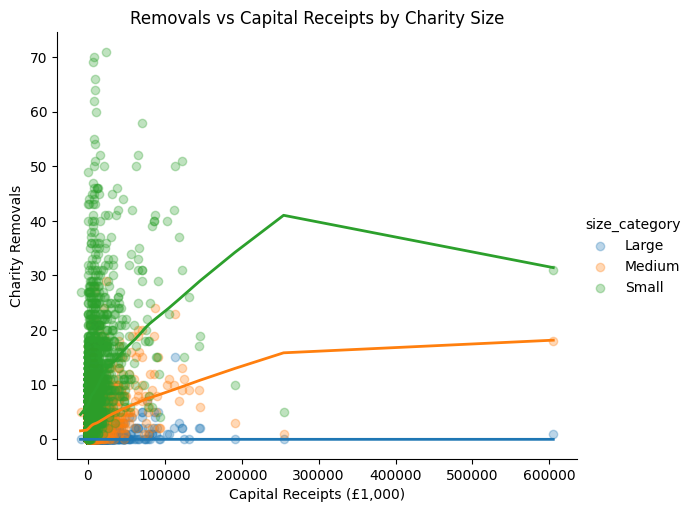

In [20]:
filtered_panel_1 = filtered_panel.copy()
filtered_panel_1['value_thousands'] = filtered_panel_1['value'] * 1000

sns.lmplot(
    data=filtered_panel_1,
    x='value_thousands', y='removals',
    hue='size_category',  # group by charity size
    lowess=True,
    scatter_kws={'alpha':0.3},
    line_kws={'linewidth':2},
    height=5, aspect=1.2
)

plt.xlabel('Capital Receipts (£1,000)')
plt.ylabel('Charity Removals')
plt.title('Removals vs Capital Receipts by Charity Size')
plt.show()

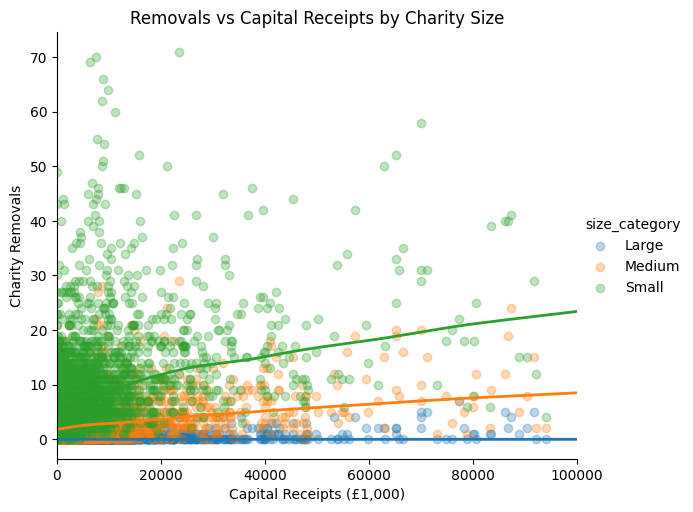

In [21]:
sns.lmplot(
    data=filtered_panel_1,
    x='value_thousands', y='removals',
    hue='size_category',
    lowess=True,
    scatter_kws={'alpha':0.3},
    line_kws={'linewidth':2},
    height=5, aspect=1.2
)

plt.xlabel('Capital Receipts (£1,000)')
plt.ylabel('Charity Removals')
plt.title('Removals vs Capital Receipts by Charity Size')
plt.xlim(0, 100000)  # limit to £100 million
plt.show()


In [22]:
test = filtered_panel.groupby("local_authority").size().reset_index(name="value")
test["value"].min()

np.int64(9)